## Материалы

Презентация: https://disk.yandex.com/i/NlDXq16o_zRvqQ

## План проекта

### Предобработка данных

1. Открыть
2. Проведем общий обзор датафреймов.
3. Исследовать наличие дубликатов
4. Разобраться с возможностью удаления/заполнения пропущенных полей в internal
5. Исследовать столбец operator_id. На какие колл-центры приходятся пропущенные id (равномерно распределены или на один - два). По итогам принять решение об заполнении/удалении. Удаление отдельных строк? Или отдельных колл-центров (где нет заполенных операторов). Заполнение? По какому принципу?
6. Исследовать столбец call count на наличие аномальных значений.
7. Исследовать столбец total_call_duration на наличие аномальных значений.
8. Распределение операторов по колл-центрам.
9. Преобразовать данные в столбце date (нас интересуют только даты).
10. За какой период у нас данные? По всем ли колл-центрам этот период одинаков.
11. Исследовать корректность заполнения (наличие аномальных значений) в столбцах direction и internal. 
12. Проверить совпадение значений в столбцах user_id в обоих дата фреймах.

###  Поиск и формулирование критериев эффективности операторов. Исследовательский анализ данных.

1. Критерии эффективности (предложение).
2. Исследование разницы в работе КЦ на разных тарифах.
3. Исследование рабочего времени, которое операторы проводят за звонками (с разбивкой по тарифным группам).
4. Исследование количества и доли пропущенных входящих звонков.
5. Поиск операторов без пропущенных звонков.
6. Исследование длительности ожидания клиентов.
7. Сводный отчет по неэффективным операторам.

### Проверка гипотез

1. Проверка гипотезы о равенстве среднего времени работы на телефоне для операторов тарифных групп А и В, В и С, А и В.
2. Проверка гипотезы о равенстве среднего времени ожидания ответа неэффективных операторов для тарифных групп А и В, В и С, А и В.


### Подготовка выводов

1. Критерии оценки эффективности операторов
2. Количество эффективных-неэффективных операторов по колл-центрам
3. Сформулировать сильные и слабые стороны предложенного подхода
4. Сформулировать ЦА для потенциального программного продукта
5. Рекомендации по целесообразности разработки

## Выполнение задач проекта

### Предобработка данных

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
import datetime as dt
from plotly import graph_objects as go
import math as mth


#### Открытие датафреймов

In [2]:
try:
    path = ''
    data_ds = pd.read_csv(path + '')
except:
    print ("Какая то ошибка")

In [3]:
try:
    path = ''
    data_cl = pd.read_csv(path + '')
except:
    print ("Какая то ошибка")

#### Обзор датафреймов

In [4]:
data_ds.info()
display(data_ds.head(10))
data_ds.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


Обзор файлов выделяет следующие вопросы:
1. В столбце internal отсутствуют часть значений. Поскольку их всего 117 из 53902 (чуть более 0,02%, то строки с этими значениями можно удалить).
2. В столбце operator_id отсутствуют часть значений (8172 из 53902). Это довольно много - 15,2%. Но цель нашего исследования - эффективность операторов. Поэтому их надо идентифицировать. Но заполнение средним или медианным значением нам может не подойти. Мы даже не можем сказать по скольки операторам реально эти данные. Значит, приемлемый метод в данном случае все же удаление. Однако, прежде чем принять окончательное решение, посмотрим относятся ли эти данные ко всем КЦ, к одному, или к нескольким.
3. Вызывают вопросы также и максимальные значения в столбцах calls_count, call_duration, total_call_duration. Предполагаю, что это следствие наличия значений NaN в operator_id
4. Ну и вопрос к типу переменной в столбце operator_id. Он не должен быть вещественным. И скорее всего это тоже следствие наличия NaN.
5. Также нужно обратить внимание на то, что из столбца date нам нужна только информация о дате (время не меняется, т.е. мы имеем дело с информацией за день).

In [5]:
data_cl.info()
display(data_cl.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Определим, а по скольким КЦ из 732 у нас есть данные. Видим, что у нас есть данные по 307 КЦ.

In [6]:
data_us=data_ds.groupby(['user_id'], as_index = False).agg({'date': 'count'})
data_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307 entries, 0 to 306
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  307 non-null    int64
 1   date     307 non-null    int64
dtypes: int64(2)
memory usage: 7.2 KB


#### Проверка наличия и удаление дубликатов.

In [7]:
print ('Дубликатов в таблице data_ds:', data_ds.duplicated().sum())

Дубликатов в таблице data_ds: 4900


Видим, что дубликатов много. Их мы удалим, и после этого посмотрим на таблицу заново. Что изменилось.

In [8]:
data_ds = data_ds.drop_duplicates()
data_ds.reset_index(drop=True, inplace=True)
data_ds.info()
display(data_ds.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49002 entries, 0 to 49001
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
9,166377,2019-08-06 00:00:00+03:00,out,False,881278.0,True,3,0,29


In [9]:
data_ds.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,49002.000000,41546.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,916523.315409,16.462777,866.282091,1156.558202
std,598.558965,21230.041008,63.604098,3775.503352,4451.473661
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900790.500000,1.000000,0.000000,46.000000
50%,167158.000000,913938.000000,4.000000,37.000000,208.000000
75%,167819.000000,937708.000000,12.000000,570.000000,901.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


#### Удаление строк с пропущенными значениями internal

1. Видим, что строк с пропущенным значением internal осталось только 10. Их просто удалим.
2. По строкам с пустым значением в стоблце operator_id ситуация радикально не изменилось. Процентное соотношение тоже сохранилось 15,2%. Будем смотреть распределение по КЦ и принимать решение.

Используя метод dropna, удали строки, где отсутствует значение в столбце 'internal'

In [10]:
data_ds = data_ds.dropna(subset=['internal'])
data_ds.reset_index(drop=True, inplace=True)
data_ds.info()
display(data_ds.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              48892 non-null  int64  
 1   date                 48892 non-null  object 
 2   direction            48892 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41491 non-null  float64
 5   is_missed_call       48892 non-null  bool   
 6   calls_count          48892 non-null  int64  
 7   call_duration        48892 non-null  int64  
 8   total_call_duration  48892 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.0+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
9,166377,2019-08-06 00:00:00+03:00,out,False,881278.0,True,3,0,29


In [11]:
data_ds.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,48892.000000,41491.000000,48892.000000,48892.000000,48892.000000
mean,167294.492841,916516.771155,16.495214,868.088788,1158.976458
std,598.675508,21234.081589,63.671633,3779.549967,4456.180933
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900790.000000,1.000000,0.000000,46.000000
50%,167158.000000,913938.000000,4.000000,37.000000,210.000000
75%,167819.000000,937708.000000,12.000000,573.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


К сожалению, удаление пропусков в столбце 'internal' не исправило ситуацию в датафрейме в целом.

#### Исследование и предобработка столбца operator_id

Проанализируем пропуски в столбце operator_id. Для этого вынесем в отдельный датафрейм строки с пропущенными значениями 'operator_id'

In [12]:
df_filter = data_ds['operator_id']. isna() 
data_ds_cc= data_ds [df_filter]
print(data_ds_cc)
data_cc_op=data_ds_cc.groupby(['user_id'], as_index = False).agg({'date': 'count'})
data_cc_op.head(10)

       user_id                       date direction internal  operator_id  \
0       166377  2019-08-04 00:00:00+03:00        in    False          NaN   
7       166377  2019-08-05 00:00:00+03:00        in    False          NaN   
8       166377  2019-08-06 00:00:00+03:00        in    False          NaN   
16      166377  2019-08-07 00:00:00+03:00        in    False          NaN   
26      166377  2019-08-12 00:00:00+03:00        in    False          NaN   
...        ...                        ...       ...      ...          ...   
48868   168601  2019-11-27 00:00:00+03:00        in    False          NaN   
48872   168601  2019-11-28 00:00:00+03:00        in    False          NaN   
48880   168603  2019-11-28 00:00:00+03:00        in    False          NaN   
48884   168606  2019-11-08 00:00:00+03:00        in    False          NaN   
48891   168606  2019-11-19 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  
0 

,user_id,date
0,166377,37
1,166391,14
2,166392,46
3,166399,11
4,166405,109
5,166406,54
6,166407,37
7,166428,32
8,166481,9
9,166482,40


In [13]:
data_cc_op.describe()

,user_id,date
count,305.000000,305.000000
mean,167452.793443,24.265574
std,611.753261,23.577942
min,166377.000000,1.000000
25%,166971.000000,6.000000
50%,167451.000000,16.000000
75%,167995.000000,35.000000
max,168606.000000,135.000000


In [14]:
data_ds_cc['direction'].unique()

array(['in', 'out'], dtype=object)

In [15]:
data_ds_cc_gr=data_ds_cc.groupby(['direction'], as_index = False).agg({'calls_count': 'sum'})
data_ds_cc_gr.head(10)

,direction,calls_count
0,in,103884
1,out,515


In [16]:
data_ds_cc['is_missed_call'].unique()

array([ True, False])

In [17]:
data_ds_cc_gr_m=data_ds_cc.groupby(['is_missed_call'], as_index = False).agg({'calls_count': 'sum'})
data_ds_cc_gr_m.head(10)

,is_missed_call,calls_count
0,False,965
1,True,103434


Обзор полученного фрейма показывает, что пропуски есть примерно у половины КЦ(305  из 732) и распределены достаточно равномерно. Кроме того, подавляющее большинство пропусков - пропущенные входящие звонки. Возможно, они просто не были распределены на операторов.
Построим гистограмму, чтобы визуализировать распределение пропусков.

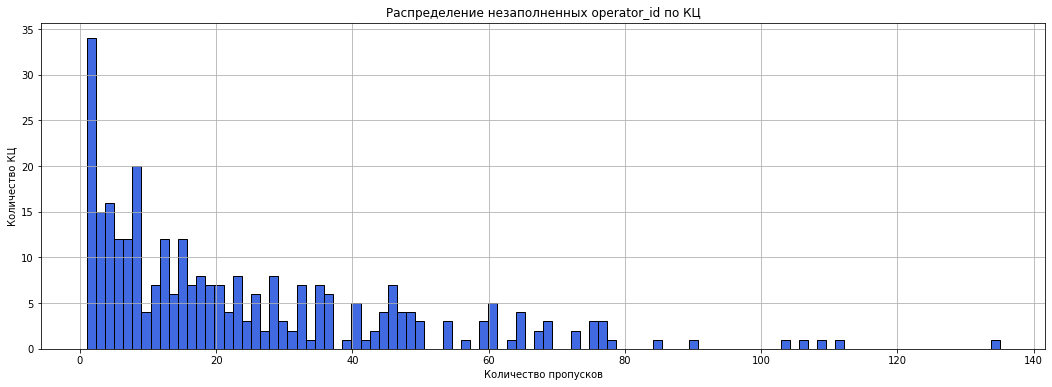

In [18]:
plt.figure(figsize = (18,6))
data_cc_op['date'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение незаполненных operator_id по КЦ', xlabel = 'Количество пропусков', ylabel = 'Количество КЦ')
plt.show()

Пропуски распределены достаточно равномерно (лишь в 5 КЦ их больше 100). Поэтому для дальнейшей работы просто удалим строки, где есть пропуски в столбце 'operator_id'. Вновь используем метод dropna()

In [19]:
data_ds_f = data_ds.dropna(subset=['operator_id'])
data_ds_f.reset_index(drop=True, inplace=True)
data_ds_f.info()
display(data_ds_f.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              41491 non-null  int64  
 1   date                 41491 non-null  object 
 2   direction            41491 non-null  object 
 3   internal             41491 non-null  object 
 4   operator_id          41491 non-null  float64
 5   is_missed_call       41491 non-null  bool   
 6   calls_count          41491 non-null  int64  
 7   call_duration        41491 non-null  int64  
 8   total_call_duration  41491 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 2.6+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
1,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
3,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
4,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
6,166377,2019-08-06 00:00:00+03:00,out,False,881278.0,True,3,0,29
7,166377,2019-08-06 00:00:00+03:00,out,False,880020.0,True,5,0,70
8,166377,2019-08-06 00:00:00+03:00,out,True,881278.0,True,2,0,5
9,166377,2019-08-06 00:00:00+03:00,out,False,880020.0,False,5,800,819


In [20]:
data_ds_f.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,41491.000000,41491.000000,41491.000000,41491.000000,41491.000000
mean,167301.113543,916516.771155,16.921381,1010.940011,1323.153238
std,600.513986,21234.081589,59.786187,4066.666485,4788.953155
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900790.000000,1.000000,0.000000,67.000000
50%,167175.000000,913938.000000,4.000000,106.000000,289.000000
75%,167827.000000,937708.000000,14.000000,772.000000,1107.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


Объеденим дата фрейм 

data_fin_both=data_fin_a.merge(data_fin_b, on='user_id', how='inner')

#### Исследовать столбец call count на наличие аномальных значений.

Видим, что удаление строк с пропусками не сказалось на максимальных значениях в столбцах calls_count, call_duration, total_call_duration. Мое предположение было ошибочным. Посмотрим на распределение значений в этих столбцах, но прежде приведем operator_id к целочисленному типу. 

In [21]:
data_ds_f.loc[:,'operator_id'] = data_ds_f.loc[:,'operator_id'].astype('int')
data_ds_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              41491 non-null  int64 
 1   date                 41491 non-null  object
 2   direction            41491 non-null  object
 3   internal             41491 non-null  object
 4   operator_id          41491 non-null  int64 
 5   is_missed_call       41491 non-null  bool  
 6   calls_count          41491 non-null  int64 
 7   call_duration        41491 non-null  int64 
 8   total_call_duration  41491 non-null  int64 
dtypes: bool(1), int64(5), object(3)
memory usage: 2.6+ MB


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [22]:
data_ds_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              41491 non-null  int64 
 1   date                 41491 non-null  object
 2   direction            41491 non-null  object
 3   internal             41491 non-null  object
 4   operator_id          41491 non-null  int64 
 5   is_missed_call       41491 non-null  bool  
 6   calls_count          41491 non-null  int64 
 7   call_duration        41491 non-null  int64 
 8   total_call_duration  41491 non-null  int64 
dtypes: bool(1), int64(5), object(3)
memory usage: 2.6+ MB


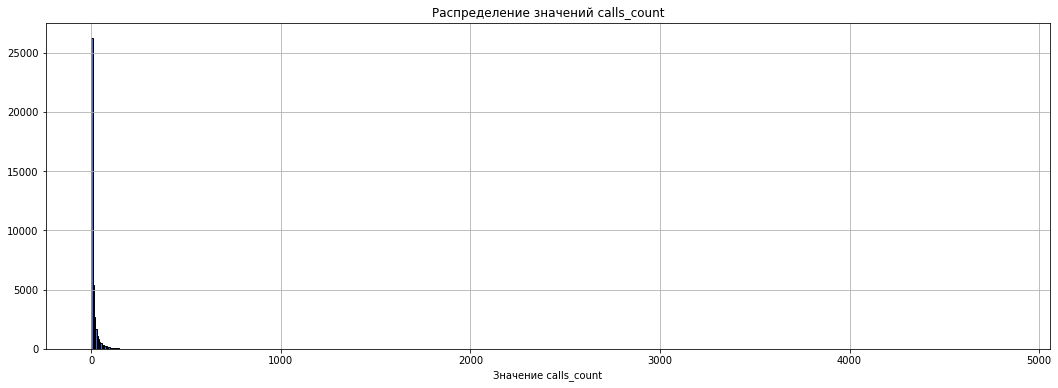

In [23]:
plt.figure(figsize = (18,6))
data_ds_f['calls_count'].hist(bins=700, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение значений calls_count', xlabel = 'Значение calls_count')
plt.show()

Оценим сколько строк удалится, если убрать аномально большие значения. Для начала будем считать аномальным значением calls_count > 100. Сравним количество строк с этими значениями и без них. Исходим из того, что даже если коллцентр работает круглосуточно (т.е. под одним operator_id выступают три разных человека, которые работают по 8 часов (при чем 1 час на обед и 1 час на прочие перерывы). Итого каждый из них может звонить по 6 часов, а все вместе 18 часов. Пусть на звонок уходит 3 минуты. В это случае до 20 звонков в час. И за сутки не более 360 звонков с одного рабочего места. Будем считать, что не более 300.А из диаграммы видим, что большая часть значений менее 100 (так как 300 формируется из звонков разных типов (входящие, исходящие, внутренние)). 

In [24]:
print('Количество строк, где количество звонков >100:', len(data_ds_f.query('calls_count > 100')))
print ('Доля строк, где количество звонков >100: {:.2f}%'.format((len(data_ds_f.query('calls_count > 100'))/len(data_ds_f)*100)))

Количество строк, где количество звонков >100: 929
Доля строк, где количество звонков >100: 2.24%


Посмотрим, как операторы с количеством звонков не больше 100 за сутки распределены по КЦ. Для этого составим срез.

In [25]:
data_ds_fi = data_ds_f.query('calls_count<=100')
data_ds_fi.reset_index(drop=True, inplace=True)
data_ds_fi.info()
display(data_ds_f.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40562 entries, 0 to 40561
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              40562 non-null  int64 
 1   date                 40562 non-null  object
 2   direction            40562 non-null  object
 3   internal             40562 non-null  object
 4   operator_id          40562 non-null  int64 
 5   is_missed_call       40562 non-null  bool  
 6   calls_count          40562 non-null  int64 
 7   call_duration        40562 non-null  int64 
 8   total_call_duration  40562 non-null  int64 
dtypes: bool(1), int64(5), object(3)
memory usage: 2.5+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-05 00:00:00+03:00,out,True,880022,True,3,0,5
1,166377,2019-08-05 00:00:00+03:00,out,True,880020,True,1,0,1
2,166377,2019-08-05 00:00:00+03:00,out,True,880020,False,1,10,18
3,166377,2019-08-05 00:00:00+03:00,out,False,880022,True,3,0,25
4,166377,2019-08-05 00:00:00+03:00,out,False,880020,False,2,3,29
5,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50
6,166377,2019-08-06 00:00:00+03:00,out,False,881278,True,3,0,29
7,166377,2019-08-06 00:00:00+03:00,out,False,880020,True,5,0,70
8,166377,2019-08-06 00:00:00+03:00,out,True,881278,True,2,0,5
9,166377,2019-08-06 00:00:00+03:00,out,False,880020,False,5,800,819


In [26]:
data_ds_fi_gr=data_ds_fi.groupby(['user_id'], as_index = False).agg({'operator_id': 'nunique'})
data_ds_fi_gr.head(10)

,user_id,operator_id
0,166377,5
1,166391,2
2,166392,3
3,166399,1
4,166405,10
5,166406,3
6,166407,8
7,166428,3
8,166481,1
9,166482,2


In [27]:
data_ds_fi_gr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      290 non-null    int64
 1   operator_id  290 non-null    int64
dtypes: int64(2)
memory usage: 6.8 KB


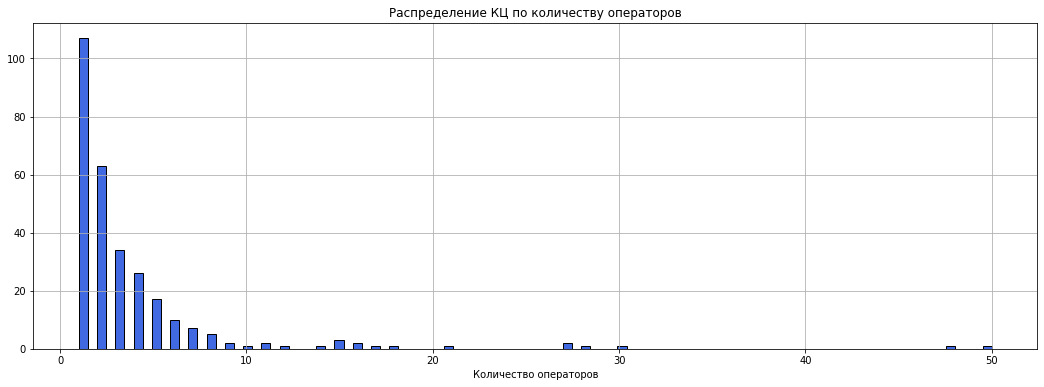

In [28]:
plt.figure(figsize = (18,6))
data_ds_fi_gr['operator_id'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение КЦ по количеству операторов', xlabel = 'Количество операторов')
plt.show()

Видим, что большая часть КЦ имеет не более 5 операторов. Лишь несколько КЦ имеют более 10 операторов

In [29]:
data_ds_fi.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,40562.000000,40562.000000,40562.000000,40562.000000,40562.000000
mean,167298.329496,916495.163355,11.166609,740.013165,935.053819
std,597.644263,21146.602119,17.039748,1559.197629,1735.110369
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166800.000000,900826.000000,1.000000,0.000000,65.000000
50%,167172.000000,913886.000000,4.000000,105.000000,273.000000
75%,167819.000000,937678.000000,12.000000,737.000000,1004.000000
max,168606.000000,973286.000000,100.000000,20282.000000,22087.000000


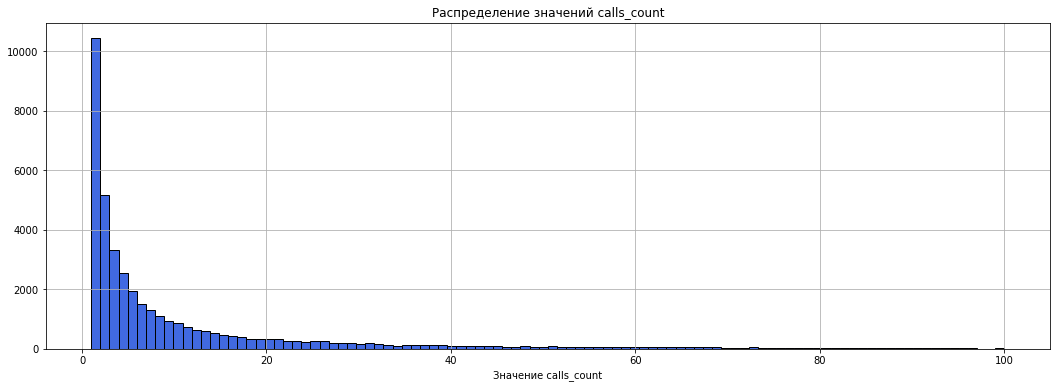

In [30]:
plt.figure(figsize = (18,6))
data_ds_fi['calls_count'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение значений calls_count', xlabel = 'Значение calls_count')
plt.show()

Видим, что после того, как мы отбросили строки, где величина calls_count мы потеряли 929 строк (2,2%). И в нашем распоряжении данные от 290 КЦ из 307 изначальных. Далее будем использовать полученный датафрейм. И еще выглядит так, что мы имеем дело с длительностью разговора в секундах.

#### Исследование столбца total_call_duration на наличие аномальных значений.

После того, как мы сделали выборку без аномальных значений в столбце calls_count, аномальные значения в столбце total_call_duration также пропали. Соответственно нет необходимости в дополнительной обработке в этой части.

#### Распределение операторов по колл-центрам

In [31]:
data_cc_op_f=data_ds_fi.groupby(['user_id'], as_index = False).agg({'operator_id': 'nunique'}).sort_values(by=['operator_id'], ascending=False)

display (data_cc_op_f.head(10))
data_cc_op_f.tail(10)


,user_id,operator_id
252,168187,50
170,167626,48
156,167497,30
259,168252,28
270,168361,27
236,168062,27
35,166680,21
16,166520,18
28,166658,17
66,166916,16


,user_id,operator_id
159,167530,1
161,167533,1
179,167664,1
163,167543,1
168,167599,1
169,167621,1
171,167630,1
54,166833,1
175,167646,1
289,168606,1


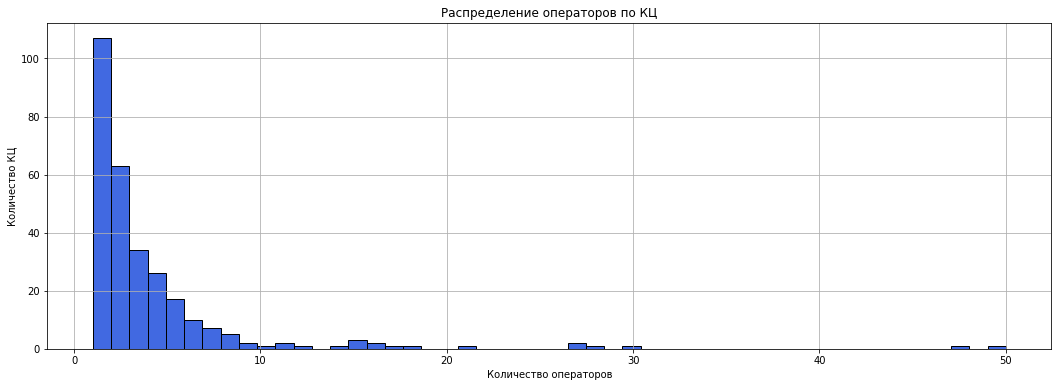

In [32]:
plt.figure(figsize = (18,6))
(
data_cc_op_f['operator_id'].hist(bins=50, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение операторов по КЦ',
             xlabel = 'Количество операторов', ylabel = 'Количество КЦ')
)
plt.show()

Видим, что большая часть КЦ имеет не более 5 операторов. Лишь несколько КЦ имеют более 10 операторов

#### Преобразавание данных в столбце date

In [33]:
print(data_ds_fi['date'].head())

data_ds_fi.loc[:,'date'] = pd.to_datetime(data_ds_fi.loc[:,'date'])
data_ds_fi.loc[:,'date'] = pd.to_datetime(data_ds_fi.loc[:,'date'].map(lambda x: dt.datetime.date(x)))

print(data_ds_fi['date'].head())


0    2019-08-05 00:00:00+03:00
1    2019-08-05 00:00:00+03:00
2    2019-08-05 00:00:00+03:00
3    2019-08-05 00:00:00+03:00
4    2019-08-05 00:00:00+03:00
Name: date, dtype: object


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


0   2019-08-05
1   2019-08-05
2   2019-08-05
3   2019-08-05
4   2019-08-05
Name: date, dtype: datetime64[ns]


#### За какой период у нас данные

In [34]:
print (data_ds_fi['date'].min())

2019-08-02 00:00:00


In [35]:
print (data_ds_fi['date'].max())

2019-11-28 00:00:00


У нас данные со второго августа по двадцать восьмое ноября. Попробуем оценить распределение количества строк по датам.

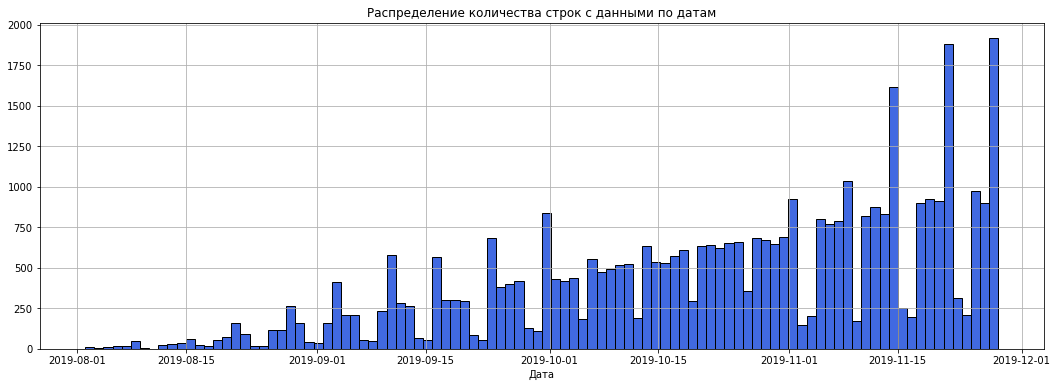

In [36]:
plt.figure(figsize = (18,6))
data_ds_fi['date'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение количества строк с данными по датам', xlabel = 'Дата')
plt.show()

Здесь нужно отметить, что за первый месяц исследования наши данные довольно малочислены. Т.е. мы видим менее чем по 250 операторам в день. Пока просто возьмем это на заметку, но избавляться от части строк за эти даты не будем пока. 

#### Проверка корректности заполнения в столбцах directon и internal.

Мы уже знаем, что в этих столбцах нет пропусков. Осталость убедиться, что в каждом из них только два варианта значений. Ну и заодно посчитать количество этих значений. Используем метод groupby.

In [37]:
data_dir_t=data_ds_fi.groupby(['direction'], as_index = False).agg({'operator_id': 'nunique'})
data_dir_t

,direction,operator_id
0,in,754
1,out,882


In [38]:
data_int=data_ds_fi.groupby(['internal'], as_index = False).agg({'operator_id': 'nunique'})
data_int.head()

,internal,operator_id
0,False,1055
1,True,568


На входящих и исходящих звонках работает примерно одинаковое количество операторов.

Проверим гипотезу о том, что все внутренние звонки исходящие (т.е. друг другу)

In [39]:
data_int_sel=data_ds_fi.query('internal == True').groupby(['direction'], as_index = False).agg({'calls_count': 'sum'})
data_int_sel.head(20)

,direction,calls_count
0,in,691
1,out,12974


Среди внутренних звонков есть и входящие и исходящие. Хотя, конечно, исходящих более чем в 20 раз больше.

#### Проверка вхождения user_id из data_ds_fi в data_cl

In [40]:
ds_user_id=data_ds_fi['user_id'].unique()

print('Количество уникальных идентификаторов КЦ в датафрейме data_ds_fi:',len(ds_user_id))

Количество уникальных идентификаторов КЦ в датафрейме data_ds_fi: 290


In [41]:
ds_user_id_cl=data_cl['user_id'].unique()

print('Количество уникальных идентификаторов КЦ в датафрейме data_cl:',len(ds_user_id_cl))

Количество уникальных идентификаторов КЦ в датафрейме data_cl: 732


Теперь создадим выборку значений из столбца 'user_id' во датафрейме ds_user_id_cl, куда войдут только значения из ds_user_id. И если ее длина будет 290, то все значения 'user_id' из data_ds_fi, содержатся в data_cl.

In [42]:
length = 0
for i in range(len(ds_user_id)):
    if ds_user_id[i-1] in ds_user_id_cl:
        length = length+1
        
print (length, 'значений user_id из датафрейма data_ds_fi входят в data_cl')

290 значений user_id из датафрейма data_ds_fi входят в data_cl


Все значения вошли.

#### Промежуточные результаты и выводы после предобработки данных

1. Удалены 4900 дубликатов.
2. В датафрейме data_ds данные изначально были только из 307 КЦ (из 732 в датафрейме с информацией по контрактам). После обработки остались данные по 290 КЦ.
3. Мы удалили 10 строк, где содержались пропуски в столбце internal.
4. Мы удалили 7401 строку, где содержались пропуски в столбце operator_id. Это значительное количество, но иначе мы бы получили искажения в последующем анализе.
5. После удаления 929 строк с аномально большими значениями в столбце calls_count у нас остались в датафрейме 40562 строки (из изначальных 53902) и данные о 290 КЦ из изначальных 307. Т.е. в результате предобработки мы удалили около 25% строк. Это значительное количество, но удаленное либо невозможно было бы вовлечь в последующий анализ, либо наши данные были бы искажены.
6. Нет КЦ, специализирующихся только на исходящих или только входящих звонках (и операторов тоже нет). 
7. В нашем распоряжении данные за период с 02 августа 2019 года по 28 ноября 2019 года. Причем мы имеем более чем по 250 строк в день, только начиная с 15 сентября. Возможно, в последующем анализе стоит отбросить более ранние даты.
8. Длительность звонков в секундах.

### Поиск и формулирование критериев эффективности операторов. Исследовательский анализ данных.

#### Критерии эффективности (предложение).

Важное замечание: определим, что неэффективность оператора необязательно следствие его плохой работы, но, возможно, и того что КЦ не обеспечивает достаточную загрузку в виде баз для исходящих звонков, либо малого количества входящих звонков.
В качестве критериев для оценки эффективности работы операторов примем:
1. Общее время, которое оператор проводит за телефонными звонками. Исходим из того, что в рабочем дне 8 часов (из них 1 час на обед и 1 час на санитарные нужды). Итого 6 часов с полной загрузкой на смену. На одном рабочем месте (с одним opertor_id) могут в 3 смены работать 3 разных человека. Тогда у нас получится фонд рабочего времени 18 часов (после анализа показателей поймем, насколько примлемо допущение о 18 часах в сутки (или для всех ли КЦ). (6 часов = 360 минут = 21 600 секунд)(18 часов = 1 080 минут = 64 800 секунд)
    1. Расчет времени за звонками для трех тарифов.
2. Количество пропущенных оператором звонков (в том случае, если звонок был на него распределен, но пропущен). Примем, что для КЦ в целом приемлемая доля пропущенных звонков 5%. Из них убираем долю нераспределенные звонки. Оставшиеся будут допустимым процентом для операторов. Если не укладываются, то неэффективны.
3. Возможно не у всех операторов в принципе есть пропущенные звонки. И это дополнительный критерий эффективности. Т.е. оператор эффективен (по этому критерию), если звонков нет вообще. Вторая ступень (есть пропущенные звонки, но время ожидания у оператора меньше). Третья ступень: есть пропущенные звонки и время ожидания больше среднего.
4. Время ожидания ответа оператора. Здесь мы сравним среднее время по пропущенным звонкам (у абонента не хватило терпения). И если наш оператор показывает среднее время ожидания (даже и по отвеченным звонкам) хуже этой величины, то он неэффективен.

Для начала поймем, а о скольки уникальных операторах у нас в принципе есть данные в нашем датафрейме.

In [43]:
ds_op_id=data_ds_fi['operator_id'].unique()

print('Количество уникальных идентификаторов операторов в датафрейме data_ds_fi:',len(ds_op_id))

Количество уникальных идентификаторов операторов в датафрейме data_ds_fi: 1092


#### Исследование разницы в работе КЦ на разных тарифах

Попробуем определить есть ли разница в модели работы между КЦ на разных тарифах. Определим количества и названия используемых тарифов. Их 3.

In [44]:
ds_tarpl=data_cl['tariff_plan'].unique()
ds_tarpl

array(['A', 'C', 'B'], dtype=object)

Выполним слияние датафреймов data_ds_fi и data_cl по столбцу user_id.

In [45]:
data_ds_fin=data_ds_fi.merge(data_cl, on='user_id', how='inner')
data_ds_fin.reset_index(drop=True, inplace=True)
data_ds_fin.info()
data_ds_fin.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40562 entries, 0 to 40561
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              40562 non-null  int64         
 1   date                 40562 non-null  datetime64[ns]
 2   direction            40562 non-null  object        
 3   internal             40562 non-null  object        
 4   operator_id          40562 non-null  int64         
 5   is_missed_call       40562 non-null  bool          
 6   calls_count          40562 non-null  int64         
 7   call_duration        40562 non-null  int64         
 8   total_call_duration  40562 non-null  int64         
 9   tariff_plan          40562 non-null  object        
 10  date_start           40562 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(5), object(4)
memory usage: 3.1+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-05,out,True,880022,True,3,0,5,B,2019-08-01
1,166377,2019-08-05,out,True,880020,True,1,0,1,B,2019-08-01
2,166377,2019-08-05,out,True,880020,False,1,10,18,B,2019-08-01
3,166377,2019-08-05,out,False,880022,True,3,0,25,B,2019-08-01
4,166377,2019-08-05,out,False,880020,False,2,3,29,B,2019-08-01
5,166377,2019-08-05,out,False,880020,True,8,0,50,B,2019-08-01
6,166377,2019-08-06,out,False,881278,True,3,0,29,B,2019-08-01
7,166377,2019-08-06,out,False,880020,True,5,0,70,B,2019-08-01
8,166377,2019-08-06,out,True,881278,True,2,0,5,B,2019-08-01
9,166377,2019-08-06,out,False,880020,False,5,800,819,B,2019-08-01


In [46]:
data_dir_tar_us=data_ds_fin.groupby(['tariff_plan','direction'], as_index = False).agg({'user_id': 'nunique', 'operator_id': 'nunique',
                                                                           'calls_count': 'median', 'call_duration': 'median',
                                                                            'total_call_duration': 'median'})
data_dir_tar_us

,tariff_plan,direction,user_id,operator_id,calls_count,call_duration,total_call_duration
0,A,in,29,186,3,295.5,342.0
1,A,out,27,278,7,19.0,379.0
2,B,in,93,276,2,259.0,305.0
3,B,out,87,329,4,29.0,226.5
4,C,in,151,292,3,238.0,281.5
5,C,out,108,275,5,16.0,224.0


Промежуточный вывод:
1. Основное отличие между КЦ на разных тарифах - разное количество операторов. В тарифе А - около 10, в тарифе B - 3-4, в тарифе C - 2-3. 


In [47]:
data_dir_tar_usm=data_ds_fin.groupby(['tariff_plan','direction'], as_index = False).agg({'calls_count': 'mean', 'call_duration': 'mean','total_call_duration': 'mean'})
data_dir_tar_usm

,tariff_plan,direction,calls_count,call_duration,total_call_duration
0,A,in,7.418523,694.226553,777.199590
1,A,out,19.726207,997.099988,1395.417479
2,B,in,6.208685,756.247768,872.463932
3,B,out,9.715111,662.544236,825.929634
4,C,in,6.627521,639.468762,722.426255
5,C,out,11.352306,667.973515,858.104175


Исходящие звонки больше похожи на продажи. При низких медианных значениях средней продолжительности разговора, мы имеем заметно более высокие средние. Что говорит о том, что есть меньшие по количеству, но значительные по времени звонки (когда продавца послушали и, может, купили).

#### Исследование рабочего времени, которое операторы проводят за звонками.

Для начала определим по каждому оператору количество дней, за которые по нему есть данные.

In [48]:
op_days=data_ds_fin.groupby(['operator_id'], as_index = False).agg({'date': 'nunique', 'call_duration': 'sum'})
op_days['work_duration']=op_days['call_duration']/op_days['date']
op_days=op_days.sort_values(by=['work_duration'], ascending=False)
op_days.reset_index(drop=True, inplace=True)
display (op_days.head(10))
op_days.tail(10)

,operator_id,date,call_duration,work_duration
0,919302,17,221327,13019.235294
1,945318,16,167793,10487.062500
2,945308,16,153963,9622.687500
3,945280,21,201113,9576.809524
4,945304,19,171462,9024.315789
5,945320,19,161515,8500.789474
6,964666,6,49557,8259.500000
7,945312,25,206111,8244.440000
8,919192,16,126352,7897.000000
9,965540,9,69142,7682.444444


,operator_id,date,call_duration,work_duration
1082,924572,1,0,0.0
1083,928282,2,0,0.0
1084,928284,1,0,0.0
1085,958458,1,0,0.0
1086,891976,1,0,0.0
1087,936296,2,0,0.0
1088,937710,1,0,0.0
1089,937716,1,0,0.0
1090,969262,1,0,0.0
1091,932246,1,0,0.0


Составим таблицу неэффективных операторов по времени работы на звонках. Т.е. тех у кого, продолжительность работы на звонках менее 1.000 за минут за сутки.

In [49]:
non_ef_work_duration=op_days.query('work_duration<1000')
non_ef_work_duration.drop(columns = ['date','call_duration'],axis = 1, inplace=True)
non_ef_work_duration.info()
print(non_ef_work_duration.head(10))
print('Количество операторов неэффективных по времени работы на звонках:',len(non_ef_work_duration['work_duration']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 355 to 1091
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   operator_id    737 non-null    int64  
 1   work_duration  737 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 17.3 KB
     operator_id  work_duration
355       947638     995.222222
356       940434     995.178571
357       959312     994.250000
358       951492     991.550000
359       939738     991.200000
360       943050     986.000000
361       937988     984.200000
362       902608     963.777778
363       944226     956.444444
364       908960     951.311688
Количество операторов неэффективных по времени работы на звонках: 737


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Ранее в пункте 2.1.6 мы пришли к выводу, что единица измерения длительности звонков у нас все же минута. Значит при односменной работе речь идет о фонде времени 360 минут в день. При трехсменной 1080. Выглядит так, что много операторов, у которых результат значительно больше даже трехсменной работы. Оценим сколько таких.

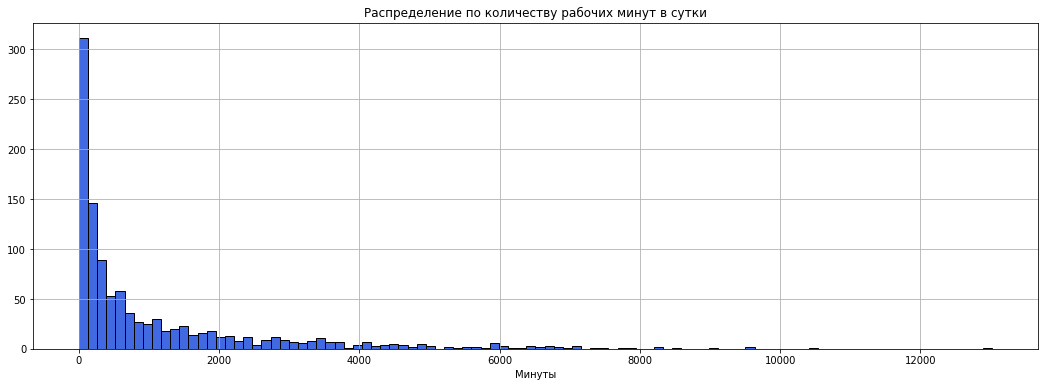

In [50]:
plt.figure(figsize = (18,6))
op_days['work_duration'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение по количеству рабочих минут в сутки', xlabel = 'Минуты')
plt.show()

In [51]:
op_days_min = op_days.query('work_duration<180')
len(op_days_min)

370

In [52]:
op_days_max = op_days.query('work_duration>1000')
len(op_days_max)

355

Мы получили результат, в соответствии с которым получается, что из 1092 операторов по показателю времени звонков эффективна только примерно третья часть 355 операторов. Критерий вполне рабочий, однако занесение данных в КЦ нужно привести к единообразию. А так - показатель рабочий. Неэффективны 737 операторов

##### Напишем функцию для расчета времени за звонками и применим ее к каждой из наших трех тарифных групп. Интересно как будут различаться показатели.

In [53]:
def w_duration (tariff):
    print ('Распределение по количеству рабочих минут в сутки для тарифа ',tariff)
    data_ds_fin_g=data_ds_fin.query('tariff_plan == @tariff')
    fop_days=data_ds_fin_g.groupby(['operator_id'], as_index = False).agg({'date': 'nunique', 'call_duration': 'sum'})
    fop_days['work_duration']=fop_days['call_duration']/fop_days['date']
    fop_days=fop_days.sort_values(by=['work_duration'], ascending=False)
    fop_days.reset_index(drop=True, inplace=True)
    plt.figure(figsize = (18,6))
    fop_days['work_duration'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set( xlabel = 'Минуты')
    plt.show()
    return fop_days['work_duration']
    

Распределение по количеству рабочих минут в сутки для тарифа  A


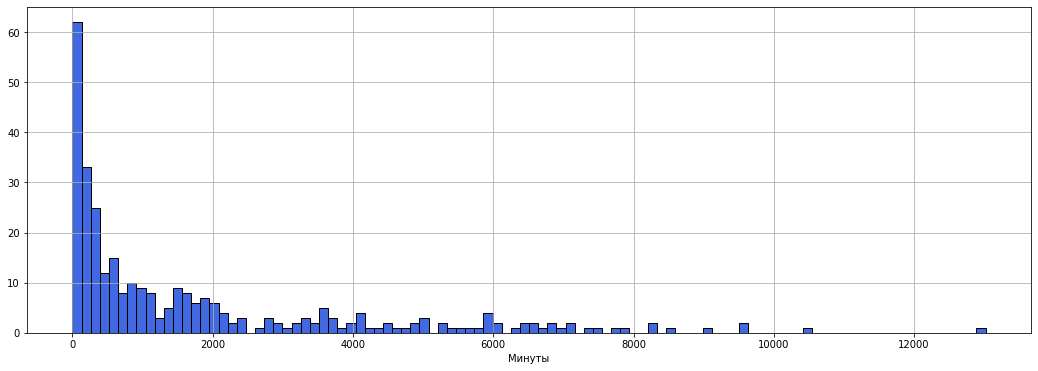

Распределение по количеству рабочих минут в сутки для тарифа  B


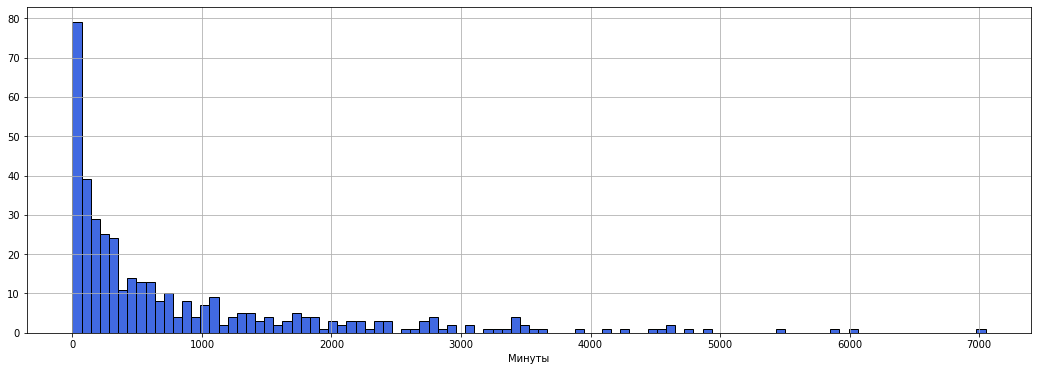

Распределение по количеству рабочих минут в сутки для тарифа  C


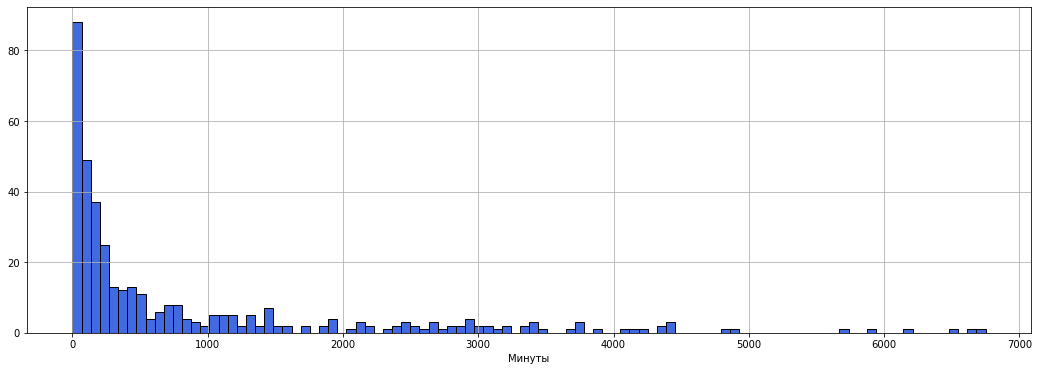

In [54]:
workdur_a=w_duration ('A')
workdur_b=w_duration ('B')
workdur_c=w_duration ('C')

В следующем разделе проекта проверим гипотезы о равенстве среднего времени на звонках для трех тарифных групп.

#### Исследование количества и доли пропущенных входящих звонков.

Для начала возьмем общее количество пропущенных КЦ звонков. Как мы установили ранее, это звонки, где для operator_id не установлено значение. Для этого возьмем датафрейм, где мы еще не удалили строки с незаполненным operator_id (только дубликаты и незаполненны поля internal удалены).

In [55]:
data_in_misssed_total = data_ds.query('direction=="in" and is_missed_call==True')
data_in_misssed_total.info()
data_in_misssed_total.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7833 entries, 0 to 48891
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              7833 non-null   int64  
 1   date                 7833 non-null   object 
 2   direction            7833 non-null   object 
 3   internal             7833 non-null   object 
 4   operator_id          684 non-null    float64
 5   is_missed_call       7833 non-null   bool   
 6   calls_count          7833 non-null   int64  
 7   call_duration        7833 non-null   int64  
 8   total_call_duration  7833 non-null   int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 558.4+ KB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
16,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
26,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
28,166377,2019-08-13 00:00:00+03:00,in,False,NaN,True,7,0,128
36,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
71,166377,2019-08-22 00:00:00+03:00,in,False,NaN,True,1,0,1
74,166377,2019-08-23 00:00:00+03:00,in,False,NaN,True,2,0,47
79,166377,2019-08-24 00:00:00+03:00,in,False,NaN,True,2,0,35


In [56]:
data_in_misssed_total_count=data_in_misssed_total.groupby(['user_id'], as_index = False).agg({'calls_count': 'sum'})
display(data_in_misssed_total_count.head(10))
display(data_in_misssed_total_count['calls_count'].sum())

,user_id,calls_count
0,166377,94
1,166391,20
2,166392,107
3,166399,11
4,166405,5535
5,166406,95
6,166407,70
7,166428,45
8,166481,57
9,166482,54


104163

Видим, что пропущено в общей сложности 104163 звонка. Довольно много. Далее из того же фрейма получим общее количество входящих звонков, также применив срез.

In [57]:
data_in_total = data_ds.query('direction=="in"')
data_in_total.info()
data_in_total.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19895 entries, 0 to 48891
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              19895 non-null  int64  
 1   date                 19895 non-null  object 
 2   direction            19895 non-null  object 
 3   internal             19895 non-null  object 
 4   operator_id          12678 non-null  float64
 5   is_missed_call       19895 non-null  bool   
 6   calls_count          19895 non-null  int64  
 7   call_duration        19895 non-null  int64  
 8   total_call_duration  19895 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 1.4+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62
16,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24
25,166377,2019-08-12 00:00:00+03:00,in,False,880028.0,False,1,407,411
26,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
28,166377,2019-08-13 00:00:00+03:00,in,False,NaN,True,7,0,128
32,166377,2019-08-13 00:00:00+03:00,in,False,880028.0,False,1,88,102
35,166377,2019-08-14 00:00:00+03:00,in,False,880026.0,False,2,197,218
36,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3


In [58]:
data_in_total_count=data_in_total.groupby(['user_id'], as_index = False).agg({'calls_count': 'sum'})
display(data_in_total_count.head(10))
display(data_in_total_count['calls_count'].sum())

,user_id,calls_count
0,166377,196
1,166391,26
2,166392,209
3,166399,24
4,166405,7709
5,166406,256
6,166407,151
7,166428,168
8,166481,58
9,166482,100


197626

Получили, что в общей сложности было 197626 звонков. Значит пропущен (не распределен) КЦ более чем каждый второй звонок. В принципе с этого места можно уже не смотреть сколько распределенных звонков пропущено уже оператором. Для этого возьмем уже наш финальный дата фрейм после всех обработок и применим к нему тот же подход.

In [59]:
data_in=data_ds_fin

In [60]:
data_in_missed = data_in.query('direction=="in" and is_missed_call==True')
data_in_missed.info()
data_in_missed.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 573 to 40554
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              684 non-null    int64         
 1   date                 684 non-null    datetime64[ns]
 2   direction            684 non-null    object        
 3   internal             684 non-null    object        
 4   operator_id          684 non-null    int64         
 5   is_missed_call       684 non-null    bool          
 6   calls_count          684 non-null    int64         
 7   call_duration        684 non-null    int64         
 8   total_call_duration  684 non-null    int64         
 9   tariff_plan          684 non-null    object        
 10  date_start           684 non-null    object        
dtypes: bool(1), datetime64[ns](1), int64(5), object(4)
memory usage: 59.4+ KB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
573,166405,2019-08-19,in,False,882684,True,1,0,7,B,2019-08-02
574,166405,2019-08-19,in,False,882686,True,1,0,5,B,2019-08-02
597,166405,2019-08-24,in,False,882684,True,1,0,14,B,2019-08-02
615,166405,2019-08-28,in,False,882686,True,2,0,50,B,2019-08-02
709,166405,2019-09-09,in,False,882686,True,1,0,8,B,2019-08-02
719,166405,2019-09-11,in,False,882684,True,1,0,29,B,2019-08-02
814,166405,2019-09-27,in,False,882684,True,1,0,16,B,2019-08-02
850,166405,2019-10-02,in,False,902532,True,1,0,111,B,2019-08-02
974,166405,2019-10-21,in,False,882690,True,1,0,11,B,2019-08-02
1023,166405,2019-10-25,in,False,902510,True,1,0,12,B,2019-08-02


In [61]:
data_in_missed_op=data_in_missed.groupby(['operator_id'], as_index = False).agg({'calls_count': 'sum'})
data_in_missed_op.columns = ['operator_id', 'missed_calls_op'] 
display(data_in_missed_op.head(10))
print('Количество пропущенных операторами звонков:', data_in_missed_op['missed_calls_op'].sum())
print('Количество операторов, пропускающих звонки:',len(data_in_missed_op['missed_calls_op']))

,operator_id,missed_calls_op
0,882680,3
1,882684,4
2,882686,6
3,882690,2
4,884408,4
5,885876,20
6,885890,26
7,887276,3
8,888406,1
9,888532,2


Количество пропущенных операторами звонков: 925
Количество операторов, пропускающих звонки: 239


Таким образом, из 197626 входящих звонков в общей сложности было пропущено 104163, из них операторами 925. Менее 1%. Можем признать, что критерий оценки по количеству пропущенных входящих звонков в целом работает. Но в нашем случае его стоит модифицировать. Т.е., признать неэффективными всех операторов, у кого есть пропущенные звонки. Таких у нас 239 человек из 1092.

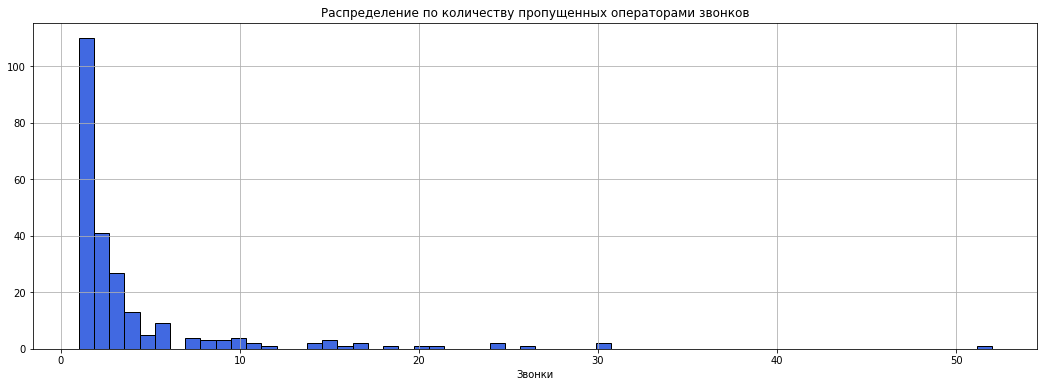

In [62]:
plt.figure(figsize = (18,6))
data_in_missed_op['missed_calls_op'].hist(bins=60, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение по количеству пропущенных операторами звонков', xlabel = 'Звонки')
plt.show()

#### Поиск операторов без пропущенных звонков

Ранее в пункте 2.2.1 мы установили, что у нас в базе 1092 оператора. Операторов, пропустивших звонки 239. Т.е. операторов без пропущенных звонков точно существуют. Их 853

#### Исследование длительности ожидания клиентов.

In [63]:
data_in_waiting=data_in_misssed_total
data_in_waiting['waiting']=(data_in_waiting['total_call_duration']-data_in_waiting['call_duration'])/data_in_waiting['calls_count']
data_in_waiting.head(10)

/tmp/ipykernel_471/2673431241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_in_waiting['waiting']=(data_in_waiting['total_call_duration']-data_in_waiting['call_duration'])/data_in_waiting['calls_count']


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2.000000
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35,5.833333
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62,15.500000
16,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0,24,12.000000
26,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34,17.000000
28,166377,2019-08-13 00:00:00+03:00,in,False,NaN,True,7,0,128,18.285714
36,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3,3.000000
71,166377,2019-08-22 00:00:00+03:00,in,False,NaN,True,1,0,1,1.000000
74,166377,2019-08-23 00:00:00+03:00,in,False,NaN,True,2,0,47,23.500000
79,166377,2019-08-24 00:00:00+03:00,in,False,NaN,True,2,0,35,17.500000


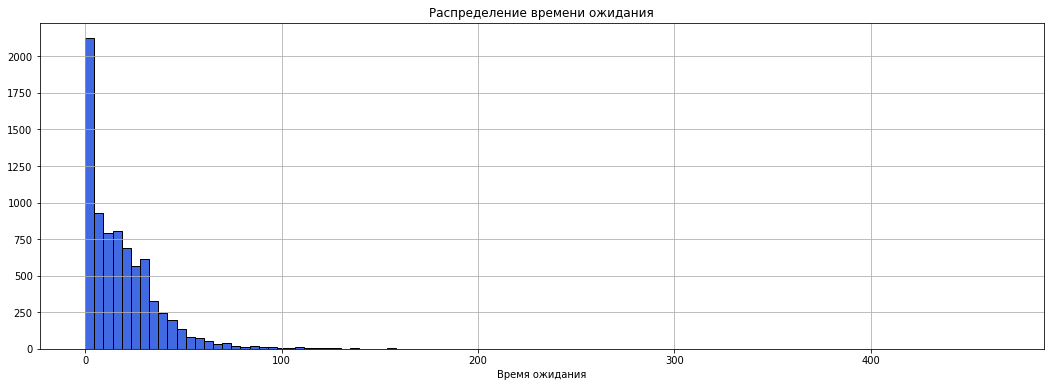

In [64]:
plt.figure(figsize = (18,6))
data_in_waiting['waiting'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение времени ожидания', xlabel = 'Время ожидания')
plt.show()

Рассчитаем медианное время ожидания для всех пропущенных звонков

In [65]:
waiting_median=data_in_waiting['waiting'].median()
print ('Медианное время ожидания на входящих звонках: ', waiting_median)

Медианное время ожидания на входящих звонках:  14.0


Однако, 14 минут. Стоит ли удивляться тому, что более 50% входящих звонков пропущено. Что-то не так с системой распределения звонков в КЦ, либо с организацией работы операторов. Однако сравним достижения наших операторов с полученным значением. Для этого из нашего финального датафрейма data_ds_fin сделаем группировку по операторам.

In [66]:
data_op_in=data_ds_fin.query('direction=="in"')

waiting_by_op=data_op_in.groupby(['operator_id'], as_index = False).agg({'calls_count':'sum','call_duration':'sum', 'total_call_duration':'sum'})
waiting_by_op.head()


,operator_id,calls_count,call_duration,total_call_duration
0,879896,58,5616,6190
1,879898,103,6351,8024
2,880020,7,299,353
3,880022,8,512,624
4,880026,24,1587,1730


In [67]:
waiting_by_op['wm']=(waiting_by_op['total_call_duration']-waiting_by_op['call_duration'])/waiting_by_op['calls_count']
waiting_by_op.head()

,operator_id,calls_count,call_duration,total_call_duration,wm
0,879896,58,5616,6190,9.896552
1,879898,103,6351,8024,16.242718
2,880020,7,299,353,7.714286
3,880022,8,512,624,14.000000
4,880026,24,1587,1730,5.958333


Сформируем таблицу операторов, неэффективных по времени ожидания, т.е. тех, у кого эта велична более 14

In [68]:
non_ef_waiting_op=waiting_by_op.query('wm>14')
non_ef_waiting_op.drop(columns = ['calls_count','call_duration','total_call_duration'],axis = 1, inplace=True)
non_ef_waiting_op.info()
print(non_ef_waiting_op.head(10))
print('Количество операторов c долгим временем ожидания:',len(non_ef_waiting_op['wm']))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 1 to 753
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   operator_id  386 non-null    int64  
 1   wm           386 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.0 KB
    operator_id         wm
1        879898  16.242718
6        882476  31.666667
7        882478  25.333333
8        882680  16.070707
9        882684  15.539967
10       882686  14.714099
11       882688  44.866667
12       882690  41.532164
16       884408  26.400000
17       884412  41.666667
Количество операторов c долгим временем ожидания: 386


/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


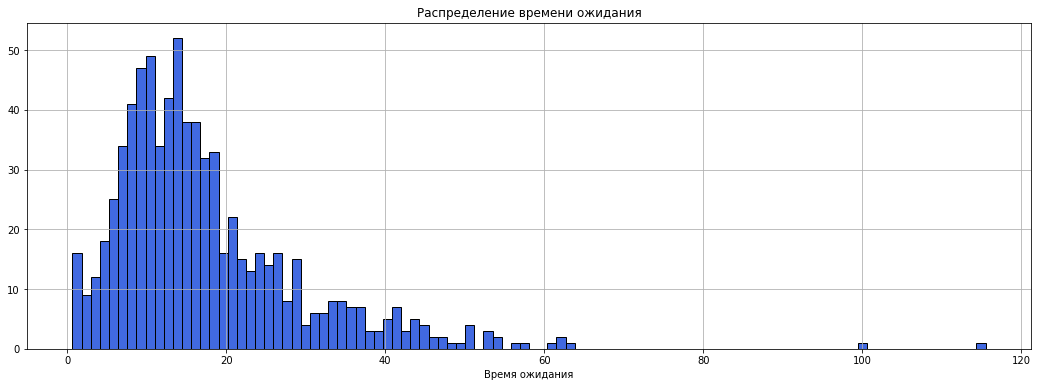

In [69]:
plt.figure(figsize = (18,6))
waiting_by_op['wm'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение времени ожидания', xlabel = 'Время ожидания')
plt.show()

In [70]:
print('Эффективны по времени ожидания клиента', len(waiting_by_op.query('wm<=14')), 'операторов из ', len(ds_op_id))

Эффективны по времени ожидания клиента 368 операторов из  1092


Критерий эффективности рабочий, хотя время ожидания велико, с моей точки зрения.

##### Напишем функцию для расчета времени ожидания заказчика и применим ее к каждой из наших трех тарифных групп. Интересно как будут различаться показатели.

In [71]:
def w_waiting (tariff):
    print ('Распределение по времени ожидания для тарифа ',tariff)
    fwaiting_median=waiting_median
    fdata_op_in=data_ds_fin.query('direction=="in" and tariff_plan == @tariff')
    fwaiting_by_op=fdata_op_in.groupby(['operator_id'], as_index = False).agg({'calls_count':'sum','call_duration':'sum', 'total_call_duration':'sum'})
    fwaiting_by_op['wm']=(fwaiting_by_op['total_call_duration']-fwaiting_by_op['call_duration'])/fwaiting_by_op['calls_count']
    fnon_ef_waiting_op=fwaiting_by_op.query('wm>14')
    #fnon_ef_waiting_op.drop(columns = ['calls_count','call_duration','total_call_duration'],axis = 1, inplace=True)
    fnon_ef_waiting_op.reset_index(drop=True, inplace=True)
    plt.figure(figsize = (18,6))
    fnon_ef_waiting_op['wm'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set( xlabel = 'Время ожидания')
    plt.show()
    
    return fnon_ef_waiting_op['wm']

Распределение по времени ожидания для тарифа  A


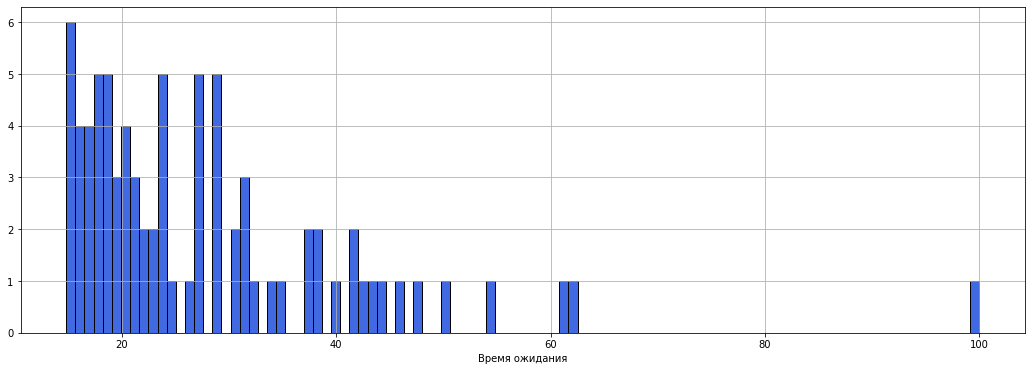

Распределение по времени ожидания для тарифа  B


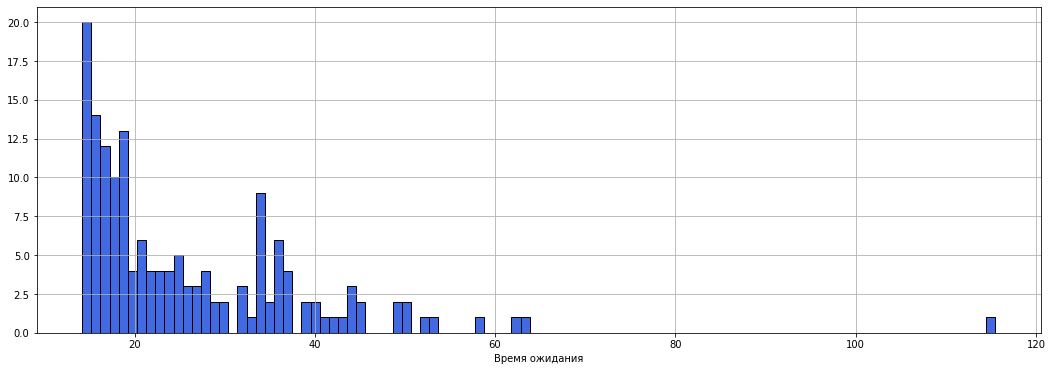

Распределение по времени ожидания для тарифа  C


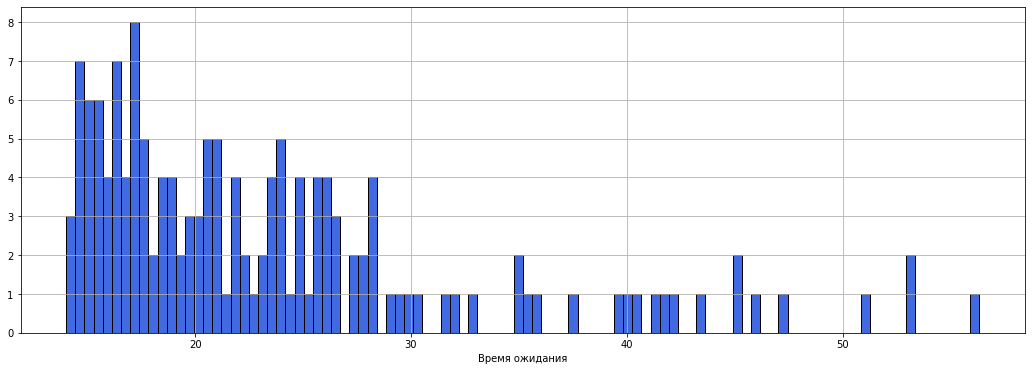

In [72]:
waiting_a=w_waiting ('A')
waiting_b=w_waiting ('B')
waiting_c=w_waiting ('C')

#### Сводный отчет по неэффективным операторам

Для начала создам фрейм, куда войдут operator_id и user_id


In [73]:
non_ef_op = data_ds_fin.groupby(['user_id','operator_id'], as_index = False).agg({'calls_count': 'sum'})
non_ef_op.drop(columns = ['calls_count'],axis = 1, inplace=True)
print(non_ef_op.head())

   user_id  operator_id
0   166377       880020
1   166377       880022
2   166377       880026
3   166377       880028
4   166377       881278


Вспомним также о трех фреймах по неэффективности, которые сформировали ранее.

In [74]:
non_ef_waiting_op['wm']=1
display(non_ef_waiting_op.head())
data_in_missed_op['missed_calls_op']=1
display(data_in_missed_op.head())
non_ef_work_duration['work_duration']=1
display(non_ef_work_duration.head())

/tmp/ipykernel_471/898702528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ef_waiting_op['wm']=1


,operator_id,wm
1,879898,1
6,882476,1
7,882478,1
8,882680,1
9,882684,1


,operator_id,missed_calls_op
0,882680,1
1,882684,1
2,882686,1
3,882690,1
4,884408,1


/tmp/ipykernel_471/898702528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_ef_work_duration['work_duration']=1


,operator_id,work_duration
355,947638,1
356,940434,1
357,959312,1
358,951492,1
359,939738,1


Объеденим все четыре таблици в общий датафрейм non_effective

In [75]:
non_ef_op=non_ef_op.merge(non_ef_waiting_op, on='operator_id', how='outer')

non_ef_op=non_ef_op.merge(data_in_missed_op, on='operator_id', how='outer')
non_ef_op=non_ef_op.merge(non_ef_work_duration, on='operator_id', how='outer')
non_ef_op = non_ef_op.fillna(0)
non_ef_op['total_non_ef'] = non_ef_op['wm']+non_ef_op['missed_calls_op']+non_ef_op['work_duration']

non_ef_op.reset_index(drop=True, inplace=True)
non_ef_op.info()
non_ef_op.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          1092 non-null   int64  
 1   operator_id      1092 non-null   int64  
 2   wm               1092 non-null   float64
 3   missed_calls_op  1092 non-null   float64
 4   work_duration    1092 non-null   float64
 5   total_non_ef     1092 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 51.3 KB


,user_id,operator_id,wm,missed_calls_op,work_duration,total_non_ef
0,166377,880020,0.0,0.0,1.0,1.0
1,166377,880022,0.0,0.0,1.0,1.0
2,166377,880026,0.0,0.0,0.0,0.0
3,166377,880028,0.0,0.0,0.0,0.0
4,166377,881278,0.0,0.0,1.0,1.0
5,166391,882476,1.0,0.0,1.0,2.0
6,166391,882478,1.0,0.0,1.0,2.0
7,166392,886892,1.0,0.0,1.0,2.0
8,166392,891900,1.0,0.0,1.0,2.0
9,166392,891906,1.0,0.0,1.0,2.0


In [76]:
non_ef_op['total_non']=non_ef_op['total_non_ef']
for i in range(len(non_ef_op)):
    #print(i)
    if non_ef_op.loc[i,'total_non_ef']>0:
        non_ef_op.loc[i,'total_non']=1
non_ef_op.head(10)

,user_id,operator_id,wm,missed_calls_op,work_duration,total_non_ef,total_non
0,166377,880020,0.0,0.0,1.0,1.0,1.0
1,166377,880022,0.0,0.0,1.0,1.0,1.0
2,166377,880026,0.0,0.0,0.0,0.0,0.0
3,166377,880028,0.0,0.0,0.0,0.0,0.0
4,166377,881278,0.0,0.0,1.0,1.0,1.0
5,166391,882476,1.0,0.0,1.0,2.0,1.0
6,166391,882478,1.0,0.0,1.0,2.0,1.0
7,166392,886892,1.0,0.0,1.0,2.0,1.0
8,166392,891900,1.0,0.0,1.0,2.0,1.0
9,166392,891906,1.0,0.0,1.0,2.0,1.0


In [77]:
print('Общее количество КЦ, где есть неэффективные операторы, ',
     len(non_ef_op.query('total_non_ef>0').groupby(['user_id'], as_index = False).agg({'operator_id': 'count'})),
      ' из ',len(ds_user_id))

Общее количество КЦ, где есть неэффективные операторы,  276  из  290


In [78]:
print('Общее количество операторов неэффективных по времени ожидания заказчика:', non_ef_op.query('wm>0')['wm'].count())

Общее количество операторов неэффективных по времени ожидания заказчика: 386


In [79]:
print('Общее количество операторов неэффективных по количеству пропущенных звонков:', non_ef_op.query('missed_calls_op>0')['missed_calls_op'].count())

Общее количество операторов неэффективных по количеству пропущенных звонков: 239


In [80]:
print('Общее количество операторов неэффективных по времени работы со звонками:', non_ef_op.query('work_duration>0')['work_duration'].count())

Общее количество операторов неэффективных по времени работы со звонками: 737


In [81]:
print('Общее количество операторов неэффективных хотя бы по одному критерию:',
      non_ef_op.query('total_non_ef>0')['total_non_ef'].count(), ' из ', non_ef_op['operator_id'].nunique())

Общее количество операторов неэффективных хотя бы по одному критерию: 889  из  1092


In [82]:
non_ef_cc=non_ef_op.groupby(['user_id'], as_index = False).agg({'operator_id': 'count','total_non': 'sum'})
non_ef_cc['non_eef_share']=non_ef_cc['total_non']/non_ef_cc['operator_id']

non_ef_cc.head(10)

,user_id,operator_id,total_non,non_eef_share
0,166377,5,3.0,0.600000
1,166391,2,2.0,1.000000
2,166392,3,3.0,1.000000
3,166399,1,1.0,1.000000
4,166405,10,9.0,0.900000
5,166406,3,2.0,0.666667
6,166407,8,8.0,1.000000
7,166428,3,3.0,1.000000
8,166481,1,1.0,1.000000
9,166482,2,2.0,1.000000


Ранее мы писали, что в 276 из 290 коллцентров есть неэффективные операторы. Лидируют те 14, где их нет. Список чемпионов:

In [83]:
print (non_ef_cc.query('non_eef_share==0'))

     user_id  operator_id  total_non  non_eef_share
12    166495            2        0.0            0.0
43    166717            1        0.0            0.0
70    166941            5        0.0            0.0
86    167011            6        0.0            0.0
107   167125            8        0.0            0.0
110   167141            1        0.0            0.0
148   167455            1        0.0            0.0
159   167530            1        0.0            0.0
183   167727            1        0.0            0.0
191   167799            1        0.0            0.0
241   168093            1        0.0            0.0
268   168315            1        0.0            0.0
274   168416            1        0.0            0.0
277   168466            2        0.0            0.0


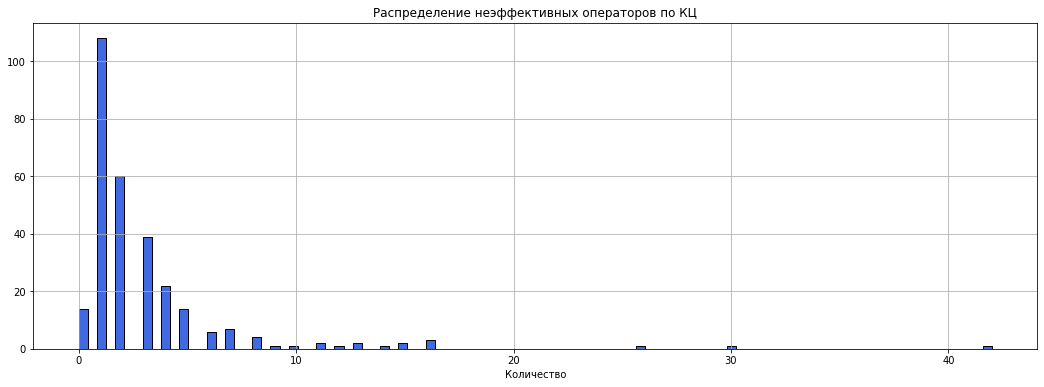

In [84]:
plt.figure(figsize = (18,6))
non_ef_cc['total_non'].hist(bins=100, color = 'royalblue', edgecolor = 'black').set(title = 'Распределение неэффективных операторов по КЦ', xlabel = 'Количество')
plt.show()

Промежуточные выводы:
1. Предложены четыре вида критериев для оценки работы операторов:
    1. Общее время, которое оператор проводит за телефонными звонками. Исходим из того, что в рабочем дне 8 часов (из них 1 час на обед и 1 час на санитарные нужды). Итого 6 часов с полной загрузкой на смену. На одном рабочем месте (с одним opertor_id) могут в 3 смены работать 3 разных человека. Тогда у нас получится фонд рабочего времени 18 часов (после анализа показателей поймем, насколько примлемо допущение о 18 часах в сутки (или для всех ли КЦ). (6 часов = 360 минут = 21 600 секунд)(18 часов = 1 080 минут = 64 800 секунд)
       1. Расчет времени за звонками для трех тарифов.
    2. Количество пропущенных оператором звонков (в том случае, если звонок был на него распределен, но пропущен). Примем, что для КЦ в целом приемлемая доля пропущенных звонков 5%. Из них убираем долю нераспределенные звонки. Оставшиеся будут допустимым процентом для операторов. Если не укладываются, то неэффективны.
    3. Возможно не у всех операторов в принципе есть пропущенные звонки. И это дополнительный критерий эффективности. Т.е. оператор эффективен (по этому критерию), если звонков нет вообще. Вторая ступень (есть пропущенные звонки, но время ожидания у оператора меньше). Третья ступень: есть пропущенные звонки и время ожидания больше среднего.
    4. Время ожидания ответа оператора. Здесь мы сравним среднее время по пропущенным звонкам (у абонента не хватило терпения). И если наш оператор показывает среднее время ожидания (даже и по отвеченным звонкам) хуже этой величины, то он неэффективен.
2. Работоспособность подтвердили  критерии общего времени на телефонных звонках, времени ожидания заказчиком и количества пропущенных звонков.
3. Подготовлен сводный отчет по эффективности операторов.
   1. Общее количество КЦ, где есть неэффективные операторы,  276  из  290
   2. Общее количество операторов, неэффективных по времени ожидания заказчика: 386
   3. Общее количество операторов неэффективных по количеству пропущенных звонков: 239
   4. Общее количество операторов неэффективных по времени работы со звонками: 737
   5. Общее количество операторов неэффективных хотя бы по одному критерию: 889  из  1092
   6. Подготовлен список 14 КЦ, где нет неэффективных операторов

### Проверка гипотез.

#### Проверка гипотезы о равенстве среднего времени работы на телефоне для операторов тарифных групп А и В, В и С, А и В.

Проверим гипотезу о равенстве среднего времени на телефонных звонках для групп А и В. Нулевая гипотеза: среднее время на телефонные звонки по группам одинаково. Альтернативная гипотеза - они отличаются. Зададим уровень значимости (pvalue) в 0.01. Распределения близки к нормальным, поэтому для проверки гипотез будем использовать t-тест. 

In [85]:
results_time_ab = st.ttest_ind(
    workdur_a, 
    workdur_b)
print (results_time_ab)
if results_time_ab.pvalue<0.01:
    print ('Среднее время на телефонных звонках для групп А и В не различаются. pvalue = ',results_time_ab.pvalue)
else:
    print ('Среднее время на телефонных звонках для групп А и В различаются. pvalue = ',results_time_ab.pvalue)


Ttest_indResult(statistic=7.0225675874144775, pvalue=5.147949986566851e-12)
Среднее время на телефонных звонках для групп А и В не различаются. pvalue =  5.147949986566851e-12


Проверим гипотезу о равенстве среднего времени на телефонных звонках для групп B и C. Нулевая гипотеза: среднее время на телефонные звонки по группам одинаково. Альтернативная гипотеза - они отличаются. Зададим уровень значимости (pvalue) в 0.01. Распределения близки к нормальным, поэтому для проверки гипотез будем использовать t-тест.


In [86]:
results_time_bc = st.ttest_ind(
    workdur_b, 
    workdur_c)
print (results_time_bc)
if results_time_bc.pvalue<0.01:
    print ('Среднее время на телефонных звонках для групп B и C не различаются. pvalue = ',results_time_bc.pvalue)
else:
    print ('Среднее время на телефонных звонках для групп B и C различаются. pvalue = ',results_time_bc.pvalue)

Ttest_indResult(statistic=-0.08088286845181432, pvalue=0.9355558526551646)
Среднее время на телефонных звонках для групп B и C различаются. pvalue =  0.9355558526551646


Проверим гипотезу о равенстве среднего времени на телефонных звонках для групп A и C. Нулевая гипотеза: среднее время на телефонные звонки по группам одинаково. Альтернативная гипотеза - они отличаются. Зададим уровень значимости (pvalue) в 0.01. Распределения близки к нормальным, поэтому для проверки гипотез будем использовать t-тест.

In [87]:
results_time_ac = st.ttest_ind(
    workdur_a, 
    workdur_c)
print (results_time_ac)
if results_time_ac.pvalue<0.01:
    print ('Среднее время на телефонных звонках для групп A и C не различаются. pvalue = ',results_time_ac.pvalue)
else:
    print ('Среднее время на телефонных звонках для групп A и C различаются. pvalue = ',results_time_ac.pvalue)

Ttest_indResult(statistic=6.724654021672447, pvalue=3.675706285397218e-11)
Среднее время на телефонных звонках для групп A и C не различаются. pvalue =  3.675706285397218e-11


Промежуточный вывод: для оценки эффективности операторов критерий среднего времени на телефоне лучше выводить отдельно для разных тарифных групп.

#### Проверка гипотезы о равенстве среднего времени ожидания ответа неэффективных операторов для тарифных групп А и В, В и С, А и В.

Проверим гипотезу о равенстве среднего времени ожидания ответа неэффективных операторов А и В. Нулевая гипотеза: среднее время ожидание по группам одинаково. Альтернативная гипотеза - они отличаются. Зададим уровень значимости (pvalue) в 0.01. Распределения близки к нормальным, поэтому для проверки гипотез будем использовать t-тест. 

In [88]:
results_waiting_ab = st.ttest_ind(
    waiting_a, 
    waiting_b)
print (results_waiting_ab)
if results_waiting_ab.pvalue<0.01:
    print ('Среднее время ожидания на телефонных звонках для групп А и В не различаются. pvalue = ',results_waiting_ab.pvalue)
else:
    print ('Среднее время ожидания на телефонных звонках для групп А и В различаются. pvalue = ',results_waiting_ab.pvalue)


Ttest_indResult(statistic=0.9362467616754383, pvalue=0.35010727950686527)
Среднее время ожидания на телефонных звонках для групп А и В различаются. pvalue =  0.35010727950686527


Проверим гипотезу о равенстве среднего времени ожидания ответа неэффективных операторов B и C. Нулевая гипотеза: среднее время ожидание по группам одинаково. Альтернативная гипотеза - они отличаются. Зададим уровень значимости (pvalue) в 0.01. Распределения близки к нормальным, поэтому для проверки гипотез будем использовать t-тест. 

In [89]:
results_waiting_bc = st.ttest_ind(
    waiting_b, 
    waiting_c)
print (results_waiting_bc)
if results_waiting_bc.pvalue<0.01:
    print ('Среднее время ожидания на телефонных звонках для групп B и C не различаются. pvalue = ',results_waiting_bc.pvalue)
else:
    print ('Среднее время ожидания на телефонных звонках для групп B и C различаются. pvalue = ',results_waiting_bc.pvalue)

Ttest_indResult(statistic=1.8784356860120617, pvalue=0.061278474579719466)
Среднее время ожидания на телефонных звонках для групп B и C различаются. pvalue =  0.061278474579719466


Проверим гипотезу о равенстве среднего времени ожидания ответа неэффективных операторов A и C. Нулевая гипотеза: среднее время ожидание по группам одинаково. Альтернативная гипотеза - они отличаются. Зададим уровень значимости (pvalue) в 0.01. Распределения близки к нормальным, поэтому для проверки гипотез будем использовать t-тест. 

In [90]:
results_waiting_ac = st.ttest_ind(
    waiting_a, 
    waiting_c)
print (results_waiting_ac)
if results_waiting_ac.pvalue<0.01:
    print ('Среднее время ожидания на телефонных звонках для групп A и C не различаются. pvalue = ',results_waiting_ac.pvalue)
else:
    print ('Среднее время ожидания на телефонных звонках для групп A и C различаются. pvalue = ',results_waiting_ac.pvalue)

Ttest_indResult(statistic=2.753405432110628, pvalue=0.006375335366306557)
Среднее время ожидания на телефонных звонках для групп A и C не различаются. pvalue =  0.006375335366306557


Промежуточный вывод: для оценки эффективности операторов критерий среднего времени ожидания для операторов лучше выводить отдельно для разных тарифных групп.

## Выводы:

### Предварительные выводы:

1. В ходе работы проведена предобработка данных:
   1. Удалены 4900 дубликатов.
   2. В датафрейме data_ds данные изначально были только из 307 КЦ (из 732 в датафрейме с информацией по контрактам). После обработки остались данные по 290 КЦ.
   3. Мы удалили 10 строк, где содержались пропуски в столбце internal.
   4. Мы удалили 7401 строку, где содержались пропуски в столбце operator_id. Это значительное количество, но иначе мы бы получили искажения в последующем анализе.
   5. После удаления 929 строк с аномально большими значениями в столбце calls_count у нас остались в датафрейме 40562 строки (из изначальных 53902) и данные о 290 КЦ из изначальных 307. Т.е. в результате предобработки мы удалили около 25% строк. Это значительное количество, но удаленное либо невозможно было бы вовлечь в последующий анализ, либо наши данные были бы искажены.
   6. Нет КЦ, специализирующихся только на исходящих или только входящих звонках (и операторов тоже нет). 
   7. В нашем распоряжении данные за период с 02 августа 2019 года по 28 ноября 2019 года. Причем мы имеем более чем по 250 строк в день, только начиная с 15 сентября. Возможно, в последующем анализе стоит отбросить более ранние даты.
   8. Длительность звонков в секундах.
   
2. Предложены четыре вида критериев для оценки работы операторов:
    1. Общее время, которое оператор проводит за телефонными звонками. Исходим из того, что в рабочем дне 8 часов (из них 1 час на обед и 1 час на санитарные нужды). Итого 6 часов с полной загрузкой на смену. На одном рабочем месте (с одним opertor_id) могут в 3 смены работать 3 разных человека. Тогда у нас получится фонд рабочего времени 18 часов (после анализа показателей поймем, насколько примлемо допущение о 18 часах в сутки (или для всех ли КЦ). (6 часов = 360 минут = 21 600 секунд)(18 часов = 1 080 минут = 64 800 секунд)
       1. Расчет времени за звонками для трех тарифов.
    2. Количество пропущенных оператором звонков (в том случае, если звонок был на него распределен, но пропущен). Примем, что для КЦ в целом приемлемая доля пропущенных звонков 5%. Из них убираем долю нераспределенные звонки. Оставшиеся будут допустимым процентом для операторов. Если не укладываются, то неэффективны.
    3. Возможно не у всех операторов в принципе есть пропущенные звонки. И это дополнительный критерий эффективности. Т.е. оператор эффективен (по этому критерию), если звонков нет вообще. Вторая ступень (есть пропущенные звонки, но время ожидания у оператора меньше). Третья ступень: есть пропущенные звонки и время ожидания больше среднего.
    4. Время ожидания ответа оператора. Здесь мы сравним среднее время по пропущенным звонкам (у абонента не хватило терпения). И если наш оператор показывает среднее время ожидания (даже и по отвеченным звонкам) хуже этой величины, то он неэффективен.
3. Работоспособность подтвердили критерии общего времени на телефонных звонках, времени ожидания заказчиком и количества пропущенных звонков.
4. Проведена сводная оценка эффективности операторов. По ней:
   1. Общее количество КЦ, где есть неэффективные операторы,  276  из  290
   2. Общее количество операторов, неэффективных по времени ожидания заказчика: 386
   3. Общее количество операторов неэффективных по количеству пропущенных звонков: 239
   4. Общее количество операторов неэффективных по времени работы со звонками: 737
   5. Общее количество операторов неэффективных хотя бы по одному критерию: 889  из  1092
   6. Подготовлен список 14 КЦ, где нет неэффективных операторов
5. Проведена проверка гипотез о равенстве средних значений рабочего времени за телефонными звонками и равенстве среднего времени ожидания ответа оператора для разных тарифных групп. Рекомендуется считать критерии отдельно для разных групп.

### Общие выводы

1. В качестве критериев оценки эффективности мы можем использовать:
   1. Общее время потраченное на телефонные звонки за смену/сутки.
   2. Время ожидания клиентом ответа на телефонный звонок.
   3. Количество пропущенных операторами звонков.
2. И по одному и по другому критерию лишь около 1/3 операторов показывают себя эффективными.
3. Расчет критериев рекомендуется производить раздельно для разных тарифных групп (либо для групп и единый, как ориентир).
4. Предлагаемый продукт может быть интересен колл-центрам с количеством работающих в смену операторов 4 и более.
5. Однако рекомендуется усовершенствовать заполнение данных: провести обучение с ответственными специалистами, которые обрабатывают данные в колл-центрах, либо доработать форматы в софте, собирающем данные.
6. Нужно четче прописать критерии заполнения данных.

## Материалы

Презентация: https://disk.yandex.com/i/NlDXq16o_zRvqQ